In [1]:
"""
Name: strawb_comp.ipynb
Authors: Stephan Meighen-Berger
Comparison with STRAW-b data comparison.
Here we use the fact that the emissions seem to happen randomly and generate enough data to get every type of observed peak
"""

'\nName: example.ipynb\nAuthors: Stephan Meighen-Berger\nExample for the package\n'

In [2]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
import imageio
from tqdm import tqdm
from scipy.interpolate import UnivariateSpline
import pickle

In [3]:
# Adding path to module
sys.path.append("../")

In [4]:
# picture path
PICS = '../pics/'

In [5]:
# Module imports
from fourth_day import Fourth_Day, config
from fourth_day.pdfs import construct_pdf

In [6]:
# Plotting standards
std_size = 6.
fontsize = 20.
lw=1.
h_length=1.

In [7]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


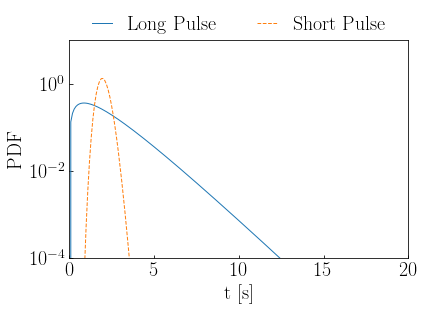

In [8]:
# Testing the emission pdfs
test_grid = np.linspace(0., 100., 1000)
gamma_test_long = construct_pdf(
    {"class": "Gamma",
     "mean": 2.,
     "sd": 1.5
    })
gamma_test_short = construct_pdf(
    {"class": "Gamma",
     "mean": 2.,
     "sd": 0.3
    })
figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
ax1.plot(test_grid,
         gamma_test_long.pdf(test_grid),
         lw=lw, label=r'$\mathrm{Long\; Pulse}$')
ax1.plot(test_grid,
         gamma_test_short.pdf(test_grid),
         lw=lw, label=r'$\mathrm{Short\; Pulse}$', ls='--')
ax1.set_xscale('linear')
ax1.set_yscale('log')
ax1.set_xlabel(r'$\mathrm{t}\;[\mathrm{s}]$', fontsize=fontsize)
ax1.set_ylabel(r'$\mathrm{PDF}$', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
# ax1.grid(True)
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h,l, loc=9, bbox_to_anchor=(0.5, +1.2),
                  ncol=5, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=False)
ax1.set_ylim(1e-4, 1e1)
ax1.set_xlim(0., 20.)
plt.tight_layout()
plt.show()
figure.savefig(PICS + "Injected_Shape.png", dpi=500,
               bbox_inches='tight')

In [9]:
# How to store
plot_data = {
    "x_grid": test_grid,
    "long_pulse": gamma_test_long.pdf(test_grid),
    "short_pulse": gamma_test_short.pdf(test_grid),
}
pickle.dump(plot_data,
            open( "C:\\Users\\steph\\Documents\\PhD\\unified_thesis_plots\\data\\injected_pdf.p", "wb"))

In [10]:
# Reuse sim data
config['scenario']['class'] = 'Stored'
config['scenario']["statistics storage"]["name"] = "straw_comp"
# Some example settings
config['scenario']['population size'] = 100
config['scenario']['duration'] = 4000
config['scenario']['organism movement'] = False
config['scenario']['exclusion'] = True
config['scenario']['injection']['rate'] = 1e-1
config['scenario']['injection']['y range'] = [0., 10.]
config['scenario']['light prop'] = {
            "switch": True,
            "x_pos": 5.,
            "y_pos": 10.,
        }
config['scenario']['detector'] = {
    "switch": True,
    "type": "PMTSpec",
    "response": True,
    "acceptance": "Flat",
    "mean detection prob": 0.5
}
# Organisms
config['organisms']['emission fraction'] = 0.1
config['organisms']['alpha'] = 10.
# Geometry
config['geometry']['volume'] = {
    'function': 'rectangle',
    'x_length': 26.,
    'y_length': 10.,
    'offset': None,
}
config['geometry']['observation'] = {
    'function': 'rectangle',
    'x_length': 26.,
    'y_length': 10.,
    "offset": np.array([0., 0.]),
}
config['geometry']["exclusion"] = {
    "function": "sphere",
    "radius": 0.15,
    "x_pos": 2.,
    "y_pos": 5.,
}
# Water
config['water']['model']['name'] = 'custom' # 'potential cylinder'
config['water']['model']['off set'] = np.array([0., 2.5])
config['water']['model']['directory'] = "../data/current/Long_run_corr/"
config['water']['model']['time step'] = 0.1
config['advanced']['starting step'] = 0

In [11]:
# Creating a fourth_day object
fd = Fourth_Day()

In [12]:
# Launching solver
fd.sim()

In [13]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

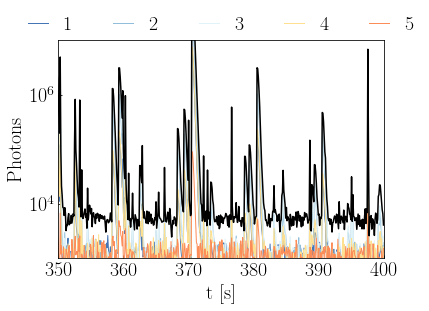

In [14]:
# Energy distributions
noise_par1 = 1e3
noise_par2 = 5e2
startpoint = 240.
width = 35
wavelengths = {
    "Detector 1": ["1", "#4575b4"],
    "Detector 5": ["2", "#91bfdb"],
    "Detector 8": ["3", "#e0f3f8"],
    "Detector 3": ["4", "#fee090"],
    "Detector 10": ["5", "#fc8d59"],
#     "Detector 2": ["6", "#d73027"],
}
smoothing = 1
norm = 1.
figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
for detector in wavelengths.keys():
    # Random noise
    noise = np.abs(np.random.normal(noise_par1, noise_par2, len(fd.t)))
    ax1.plot(fd.t,
             smooth(fd.measured[detector].values, smoothing) * norm + noise,
             lw=lw, label=r"$\mathrm{%s}$" % wavelengths[detector][0], color=wavelengths[detector][1])
noise = np.abs(np.random.normal(noise_par1, noise_par2, len(fd.t)))
total = smooth(fd.measured["Detector 1"].values, smoothing) * norm + noise
for detector in wavelengths.keys():
    if detector == "Detector 1":
        continue
    # Random noise
    noise = np.abs(np.random.normal(noise_par1, noise_par2, len(fd.t)))
    total += smooth(fd.measured[detector].values, smoothing) * norm + noise
ax1.plot(fd.t, total, color='k')
ax1.set_xscale('linear')
ax1.set_yscale('log')
ax1.set_xlabel(r'$\mathrm{t}\;[\mathrm{s}]$', fontsize=fontsize)
ax1.set_ylabel(r'$\mathrm{Photons}$', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
# ax1.grid(True)
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h,l, loc=9, bbox_to_anchor=(0.5, +1.2),
                  ncol=5, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=False)
ax1.set_ylim(1e3,1e7)
ax1.set_xlim(350, 400)
plt.tight_layout()
plt.show()

In [15]:
figure.savefig(PICS + "Strawb_Comp.pdf",
               bbox_inches='tight')

In [16]:
PMT_measurements = np.loadtxt('../data/detector/STRAW-B/PMT_Total.txt',delimiter=',')

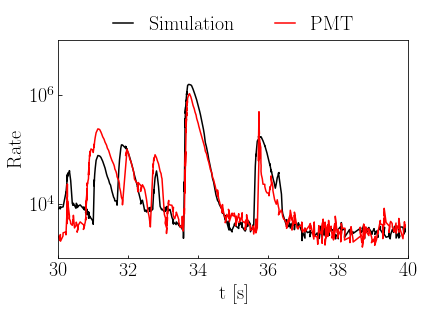

In [17]:
# Energy distributions
startpoint = 240.
width = 35
wavelengths = {
    "Detector 1": ["1", "#4575b4"],
    "Detector 5": ["2", "#91bfdb"],
    "Detector 8": ["3", "#e0f3f8"],
    "Detector 3": ["4", "#fee090"],
    "Detector 10": ["5", "#fc8d59"],
#     "Detector 2": ["6", "#d73027"],
}
window = 10
minimal_val = 30.
smoothing = 1
smoothing_2 = 1
norm = 1.
norm1 = 1./2.
norm2 = 1.5
figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
noise = np.abs(np.random.normal(noise_par1, noise_par2, len(fd.t)))
total = smooth(fd.measured["Detector 1"].values, smoothing) * norm + noise
for detector in wavelengths.keys():
    if detector == "Detector 1":
        continue
    # Random noise
    noise = np.abs(np.random.normal(noise_par1, noise_par2, len(fd.t)))
    total += smooth(fd.measured[detector].values, smoothing) * norm + noise
# ax1.plot(fd.t, total, color='k')
# -------------------------------------------
# Chosen peaks
# ax1.plot(fd.t[2145:2155] - min(fd.t[2145:2155]) + minimal_val - 0.2, total[2145:2155] / norm * 1.7, color='b')
# ax1.plot(fd.t[3785:3800] - min(fd.t[3785:3800]) + minimal_val + 1., total[3785:3800] / norm, color='b')
# ax1.plot(fd.t[2145:2155] - min(fd.t[2145:2155]) + minimal_val + 2.3, total[2145:2155] / norm * norm2, color='b')
# ax1.plot(fd.t[3801:3820] - min(fd.t[3801:3820]) + minimal_val + 3.3, total[3801:3820] / norm * norm1, color='b')
# ax1.plot(fd.t[2560:2580] - min(fd.t[2560:2580]) + minimal_val + 5.5, total[2560:2580] / norm * 1./2, color='b')
# -------------------------------------------
# Combined set
times = np.concatenate((fd.t[2145:2155] - min(fd.t[2145:2155]) + minimal_val - 0.2,
                  fd.t[3785:3800] - min(fd.t[3785:3800]) + minimal_val + 1.,
                  fd.t[2145:2155] - min(fd.t[2145:2155]) + minimal_val + 2.3,
                  fd.t[3801:3820] - min(fd.t[3801:3820]) + minimal_val + 3.3,
                  fd.t[2560:2580] - min(fd.t[2560:2580]) + minimal_val + 5.5))
counts_y = np.concatenate((
    total[2145:2155] / norm * 1.7,
    total[3785:3800] / norm,
    total[2145:2155] / norm * norm2,
    total[3801:3820] / norm * norm1,
    total[2560:2580] / norm * 1./2
))
# ax1.plot(times, counts_y, color='r')
# -------------------------------------------
# Splined with noise
spl_sim = UnivariateSpline(np.sort(times), counts_y, k=1, s=0, ext=3)
noise_par1 = 8e2
noise_par2 = 5e2
time_grid = PMT_measurements[:, 0] - 30. + minimal_val
noise = np.abs(np.random.normal(noise_par1, noise_par2, len(time_grid)))
ax1.plot(time_grid, spl_sim(time_grid) + noise, color='k', label=r'$\mathrm{Simulation}$')
# Data
ax1.plot(PMT_measurements[:, 0] - 30. + minimal_val, smooth(PMT_measurements[:, 1], smoothing_2),
         color='r', label=r'$\mathrm{PMT}$')
ax1.set_xscale('linear')
ax1.set_yscale('log')
ax1.set_xlabel(r'$\mathrm{t}\;[\mathrm{s}]$', fontsize=fontsize)
ax1.set_ylabel(r'$\mathrm{Rate}$', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
# ax1.grid(True)
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h,l, loc=9, bbox_to_anchor=(0.5, +1.2),
                  ncol=5, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=False)
ax1.set_ylim(1e3,1e7)
ax1.set_xlim(minimal_val, minimal_val + window)
plt.tight_layout()
plt.show()

In [18]:
# How to store
plot_data = {
    "x_grid": time_grid,
    "simulation_res": spl_sim(time_grid) + noise,
    "x_grid_pmt": PMT_measurements[:, 0] - 30. + minimal_val,
    "pmt_measurement": smooth(PMT_measurements[:, 1], smoothing_2)
}
pickle.dump(plot_data,
            open( "C:\\Users\\steph\\Documents\\PhD\\unified_thesis_plots\\data\\strawb_comp.p", "wb"))

In [19]:
figure.savefig(PICS + "Strawb_Combined.pdf",
               bbox_inches='tight')